# Calibrate the Laser via Dye
Using thermosensitive dyes, we can calculate a calibration curve from dye ratio -> temperature. 

Then, we can calculate the relationship between laser intensity and experienced temperature. 

This notebook can perform both tasks, recording both ambient temperature (as measured via thermistor) and laser intensity over a provided laser program. It only records both while the cameras are exposing, providing accurate results over the period where ratiometric data is available.

In [1]:
import nidaqmx
from nidaqmx.constants import AcquisitionType
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
import threading

import time, math, h5py, os

In [2]:
clock_speed = 1000.0

laser_out = "Dev1/ao0"
temp_in = "Dev1/ai4"
# cam_in = "Dev1/port0/line0:1"
cam_in = "Dev1/ai0"

In [ ]:
def kOhmsToC(ohms):
    # Using thermocouple as baseline - 9/23/25
    A = 0.3788898044e-3
    B = 3.081223060e-4
    C = -1.007874924e-7
    
    temp = A + (B * math.log(ohms)) + (C * math.pow(math.log(ohms), 3))
    return round((1/temp) - 273.15, 3) 

def VtoC(volts):
    return round(kOhmsToC(volts * 20000.0),3)

def VtokOhm(volts):
    return volts * 20000.0

def nan_helper(y): 
    return np.isnan(y), lambda z: z.nonzero()[0]

def interpolate_nans(y, x=None):
    """Interpolate NaNs in a 1D array."""
    if x is None:
        x = np.arange(len(y))

    nans = np.isnan(y)
    y = np.interp(x, x[~nans], y[~nans])
    return y

### Code Record

In [4]:
# pp = pprint.PrettyPrinter(indent=4)
def laserProgram(t):
    return 0.0
#     return t / 60 * 0.01

def recordTempTriggered(recordingLength, filename = f"tempRecording{datetime.now().strftime('%Y-%m-%d-_%H-%M')}"):
    timeStart = time.time()

    with nidaqmx.Task() as task_temp, nidaqmx.Task() as task_laser:
        task_temp.ai_channels.add_ai_voltage_chan(temp_in)
        task_temp.ai_channels.add_ai_voltage_chan(cam_in)
        task_laser.ao_channels.add_ao_voltage_chan(laser_out)
#         task_laser.timing.cfg_samp_clk_timing(clock_speed, sample_mode=AcquisitionType.CONTINUOUS)
        clock_rate = 1000
        samples_per_tp = 100 # Used to be 20, I'm thinking this way, we have one tp per capture? Although we could do 10 and get multiple?
        middle_offset = (samples_per_tp / (clock_rate * 2)) # Since we are averaging over middle_offset readings, the correct timepoint for a given reading is in the middle
        t_step = samples_per_tp/clock_rate

        task_temp.timing.cfg_samp_clk_timing(1000, sample_mode=AcquisitionType.CONTINUOUS)
        samples = []
        t = 0.0

        def callback(task_handle, every_n_samples_event_type, number_of_samples, callback_data):
            """Callback function for reading signals."""
            nonlocal t

            t += t_step
            las_pow = laserProgram(t)
            task_laser.write(las_pow * 10.0, timeout = 0)

            temps = np.array(task_temp.read(number_of_samples_per_channel=number_of_samples))
            cam_status = temps[1, :]
            temps = temps[0, :]
            if np.all(cam_status < 0.5):
                temp = 0.0
            else:
    #             print(cam_status)

                masked_temps = temps[cam_status > 0.5]
    
                temp = VtoC(np.mean(masked_temps))

#             plt.plot(np.reshape(samples, (-1, 2)))
            samples.append((time.time() - (timeStart + middle_offset), temp, las_pow))
    
    

            return 0

        task_temp.register_every_n_samples_acquired_into_buffer_event(samples_per_tp, callback)
#         task_laser.write([0.0], auto_start=False)
        task_laser.start()
        task_temp.start()

        time.sleep(recordingLength)
        task_temp.stop()

        task_laser.write([0.0], timeout = 0)
        task_laser.stop()
        

        temp = np.reshape(samples, (-1, 3))

        rows = ["{},{},{}".format(round(i, 3), j, k) for i, j, k in temp] 
        text = "\n".join(rows) 
        
        with open(f"{filename}.csv", 'w') as f: 
            f.write(text)


## Zeroing Stim
For safety purposes, I deactivate the laser by default, and provide easy access to code to deactivate it later if needed

In [ ]:
stim_length_sec = 1

# Power on a scale of 0 to 1
power = 0.0

with nidaqmx.Task() as task:
    data = []
    total_samples = int(stim_length_sec * clock_speed)
    task.ao_channels.add_ao_voltage_chan(laser_out)
    task.timing.cfg_samp_clk_timing(
        clock_speed, sample_mode=AcquisitionType.FINITE, samps_per_chan=total_samples
    )

    data = np.full((total_samples), power * 10)
    data[-1] = 0
    number_of_samples_written = task.write(data, auto_start=True)
    print(f"Generating {number_of_samples_written} voltage samples.")
    task.wait_until_done()
    task.stop()

Generating 1000 voltage samples.


## Demo Continious Recording
This code should show valid values while the cameras are capturing, and zeros otherwise.

In [ ]:
samples_per_loop = 100

with nidaqmx.Task() as task_cam, nidaqmx.Task() as task_temp:
    task_temp.ai_channels.add_ai_voltage_chan(temp_in)
    task_temp.ai_channels.add_ai_voltage_chan(cam_in)

    task_temp.timing.cfg_samp_clk_timing(1000, sample_mode=AcquisitionType.CONTINUOUS)

    def callback(task_handle, every_n_samples_event_type, number_of_samples, callback_data):
        """Callback function for reading signals."""
        temps = np.array(task_temp.read(number_of_samples_per_channel=samples_per_loop))
        cam_status = temps[1, :]
        temps = temps[0, :]
        if np.all(cam_status < 0.5):
            print(0.000, end="\r")
        else:
            masked_temps = temps[cam_status > 0.5]

            print(VtoC(np.mean(masked_temps)), end="\r")

        return 0

    task_temp.register_every_n_samples_acquired_into_buffer_event(samples_per_loop, callback)

    task_temp.start()

    input("Running task. Press Enter to stop")

    task_temp.stop()

Running task. Press Enter to stop 


In [8]:
raise BrokenPipeError("This is to stop the autorun from turning on the laser")

BrokenPipeError: This is to stop the autorun from turning on the laser

Provide the schedule for the laser. `t` is in seconds, and the laser output is from `0` to `1`. This allows for custom testing & calibration for any metric or range. The data is recorded in parallel with the thermistor output and timestamps for ease of processing

In [ ]:
def laserProgram(t):
#     if t > 120:
#         return ((max(210 - t, 0) / 60) * 0.04) + 0.00
    return ((max(t - 40, 0) / 60) * 0.035) + 0.00
#     return 0.0


In [ ]:
duration_sec = 4 * 60 # Just needs to be longer than the camera acquisition time. The processing code will discard any excess anyways.

In [ ]:
# filename = "dyeCalib_IL_082" # For dye -> temp calibration where the laser is 0
filename = "dyeLaserCalib_IL_085" # For laser -> temp calibration where the laser is varied
if os.path.exists(filename+".csv"):
    
    input("This file already exist, make sure to change the name if you don't want to overwrite it.")

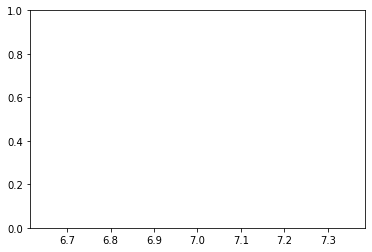

100%|██████████| 240/240 [04:16<00:00,  1.07s/it]


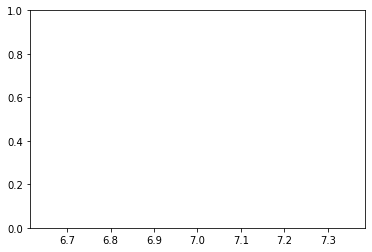

In [ ]:
# Record and show a fun little progress graph.
plt.ion() 
fig = plt.figure()
ax = fig.add_subplot(111) 

hfig = display(fig, display_id=True)

record = threading.Thread(target=recordTempTriggered, args=(duration_sec, filename)) 
record.start()
line = ax.axvline(x = 7, c = "black")
for x in tqdm(range(int(duration_sec))): 
    line.set_xdata(x * clock_speed)
    fig.canvas.draw() 
    fig.canvas.flush_events() 
    hfig.update(fig)
    time.sleep(1)

In [ ]:
task.stop()